In [1]:
import paths as paths
import shared.locals as locals
from tinydb.queries import where
from datetime import datetime
from helpers.config import Configuration
from database.database import Database
from database.models import Commit, Project, User

database = Database(paths.DATABASE_PATH, cached=True)
config = Configuration.from_input_file(paths.CONFIG_PATH)

technologies = config.technologies
users = database.all(User.LABEL)
results = {}
dates = set()

for user in users:

    user_result = {technology: [] for technology in technologies}
    commits = database.query(Commit.LABEL, where("author_id") == user.id)
    
    for commit in sorted(commits, key=lambda x: x.timestamp):
        project_technologies = database.query(Project.LABEL, 
            where("id") == commit.project_id)[0].technologies
        
        dt = datetime.utcfromtimestamp(commit.timestamp)
        for technology in project_technologies:
            user_result[technology].append(dt)
        dates.add(dt.date())
    
    results[user.id] = user_result
    years = [date.year for date in dates]

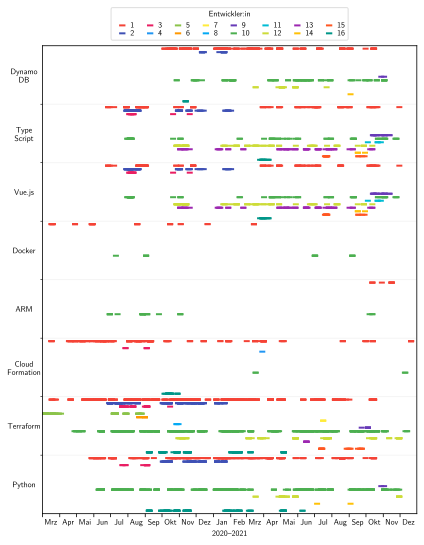

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

lane_assignment = {technology: index+1 for index, technology in enumerate(technologies)}
spacings = [i/100 for i in range(45, -51, -6)]

plt.rc("font", **locals.FONT)
fig, ax = plt.subplots(figsize=(locals.TEXTWIDTH, locals.TEXTHEIGHT_SMALL))

for index, result in enumerate(results.items()):
    user, commits = result
    dt, lanes = [], []

    for technology in commits.keys():
        dt.extend(commits[technology])
        lanes.extend([lane_assignment[technology]+spacings[index]] * len(commits[technology]))
    
    ax.scatter(dt, lanes,
        color=locals.USERS[user]["color"], label=locals.USERS[user]["id"], marker="_", linewidth=2)

legend = ax.legend(title="Entwickler:in", loc="upper center", bbox_to_anchor=(0.5, 1.09),
    ncol=8, labelspacing=0.1, columnspacing=1, handletextpad=0, edgecolor=locals.FRAME_GRAY)
for handle in legend.legendHandles:
    handle.set_sizes([40])
    handle.set_linewidth(2)
legend._legend_box.sep = 4

ax.set_yticks(list(lane_assignment.values()))
ax.tick_params(axis="y", which="major", pad=15)
ax.set_yticklabels([locals.TECHNOLOGIES[technology]["short"] for technology in lane_assignment.keys()], ha="center")
ax.set_yticks([i+0.5 for i in range(1, len(technologies))], minor=True)
ax.yaxis.grid(True, which="minor", color=locals.GRID_GRAY)
ax.set_xlabel(f"{min(years)}–{max(years)}")
ax.set_xlim([min(dates).replace(day=1), max(dates).replace(day=31)])
ax.set_ylim([0.5, len(technologies)+0.5])

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment("center")

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)

ax.set_axisbelow(True)

plt.tight_layout()
plt.show()